## Import Necessary Dependancies

In [1]:
import torch
from torch import nn
import torchvision
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Defining the Transforms

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]),
])


## Import the CIFAR-10 Dataset

In [4]:
train_data = torchvision.datasets.CIFAR10(root="data",
                                          train=True,
                                          transform=transform_train,
                                          download=True)

test_data = torchvision.datasets.CIFAR10(root="data",
                                          train=False,
                                          transform=transform_test,
                                          download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(f"Number of Training Data: {len(train_data)} \nNumber of Testing Data: {len(test_data)}")

Number of Training Data: 50000 
Number of Testing Data: 10000


In [6]:
class_names = train_data.classes
print(class_names)

class_idx = train_data.class_to_idx
print(class_idx)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


### Visualizing the Images

In [7]:
def denormalize(image):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1)
    return image * std + mean

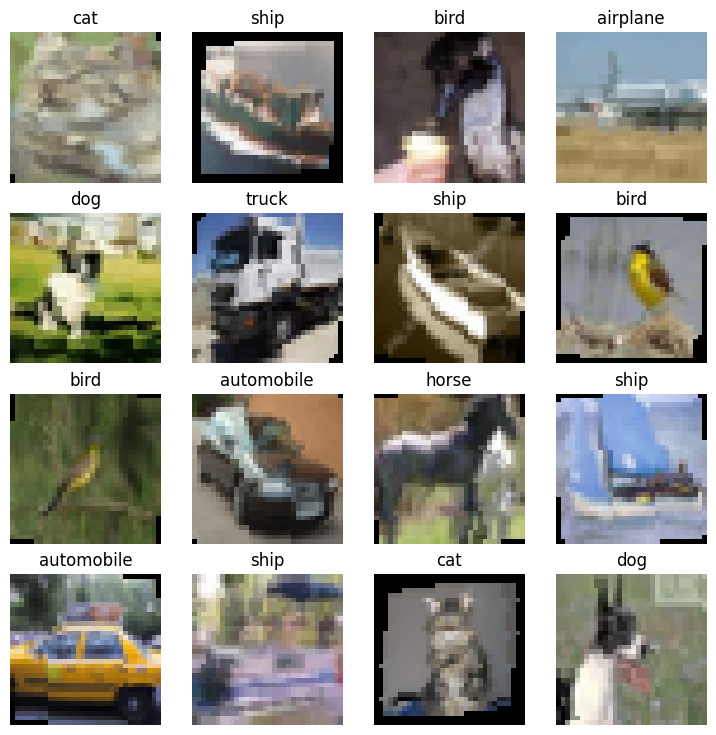

In [8]:
rows, cols = 4, 4
fig = plt.figure(figsize=(9, 9))

for i in range(1, rows*cols+1):
    rand_index = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_index]
    img = denormalize(img)
    img_for_plotting = img.permute(1, 2, 0).numpy()
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img_for_plotting.clip(0, 1))
    ax.set_title(class_names[label])
    ax.axis('off')

plt.show()

In [9]:
img, label = train_data[1]
img.shape

torch.Size([3, 32, 32])

## Defining Train and Test DataLoaders

In [10]:
num_workers = 0
batch_size = 50
valid_size = 0.15

train_size = int((1 - valid_size) * len(train_data))
valid_size = len(train_data) - train_size

train_dataset, valid_dataset = random_split(train_data, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [11]:
print(f"Number of Train data: {len(train_dataset)}")
print(f"Number of Validation data: {len(valid_dataset)}")
print(f"Number of Test data: {len(test_data)}")

Number of Train data: 42500
Number of Validation data: 7500
Number of Test data: 10000


## Defining the CNN Model Architecture

In [12]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128 * 16 * 16, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

## Defining the Accuracy function

In [13]:
def accuracy_fn(y_pred, y_true):
    """
    Calculates the accuracy of predictions.

    Args:
    - y_pred (torch.Tensor): The predictions from the model. Shape (N, num_classes) where N is the batch size.
    - y_true (torch.Tensor): The true labels. Shape (N,).

    Returns:
    - accuracy (float): The accuracy as a percentage of correct predictions.
    """
    _, predictions = torch.max(y_pred, 1)
    correct_counts = (predictions == y_true).sum().item()
    accuracy = correct_counts / y_true.size(0) * 100
    return accuracy

## Defining the Loss function and the Optimizer

In [14]:
model = CIFAR10Classifier().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [15]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

## Setup Train, Validation and Test phases

In [16]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    train_loss, train_acc, total_samples = 0, 0, 0
    for X, y in tqdm(data_loader, desc="Training"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        train_acc += accuracy_fn(y_pred=y_pred, y_true=y) * X.size(0)
        total_samples += X.size(0)

    train_loss /= total_samples
    train_acc /= total_samples
    return train_loss, train_acc

In [17]:
def validate_step(model, data_loader, loss_fn, accuracy_fn, device):
    model.eval()
    val_loss, val_acc, total_samples = 0, 0, 0
    with torch.no_grad():
        for X, y in tqdm(data_loader, desc="Validation"):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            val_loss += loss.item() * X.size(0)
            val_acc += accuracy_fn(y_pred=y_pred, y_true=y) * X.size(0)
            total_samples += X.size(0)

    val_loss /= total_samples
    val_acc /= total_samples
    return val_loss, val_acc

In [18]:
def test_step(data_loader, model, loss_fn, accuracy_fn, device):
    test_loss, test_acc, total_samples = 0, 0, 0
    model.to(device)
    model.eval()

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item() * X.size(0)
            test_acc += accuracy_fn(y_pred=test_pred, y_true=y) * X.size(0)
            total_samples += X.size(0)
    print(total_samples)
    test_loss /= total_samples
    test_acc /= total_samples
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [19]:
def train_loop(epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print('-' * 10)

        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, accuracy_fn, device=device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

        val_loss, val_acc = validate_step(model, valid_loader, loss_fn, accuracy_fn, device=device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

## Ploting Training and Validation Losses and Accuracies

In [20]:
def plot_loss_curves():
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [21]:
def plot_acc_curves():
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
train_loop(epochs=25)

In [24]:
print(f"Final Train accuracy: {train_accuracies[-1]} \nFinal Validation accuracy: {val_accuracies[-1]}")
torch.save(model.state_dict(), 'model_weights.pth')
import pickle

model_state_dict = model.state_dict()

with open('model_weights.pkl', 'wb') as f:
    pickle.dump(model_state_dict, f)

Final Train accuracy: 87.74352941176471 
Final Validation accuracy: 84.78666666666666


In [28]:
with open('model_weights.pkl', 'rb') as f:
    model_state_dict = pickle.load(f)

model.load_state_dict(model_state_dict)
model.eval()

test_step(test_loader, model, loss_fn, accuracy_fn, device)

10000
Test loss: 0.39928 | Test accuracy: 87.26%



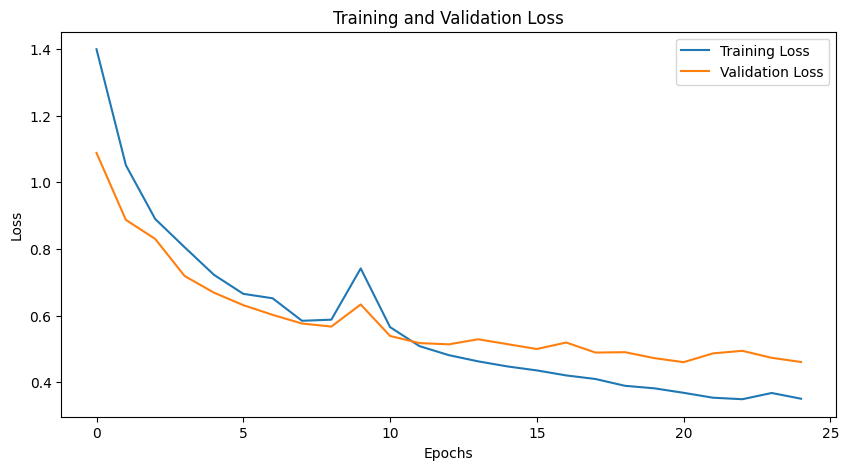

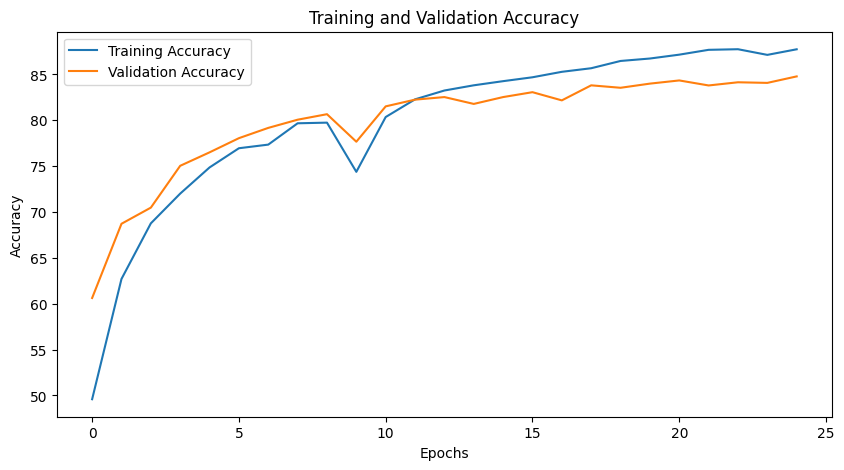

In [29]:
plot_loss_curves()
plot_acc_curves()